## Chapter 11

### Gradient 소실, 폭주

* 출력층으로 오차 gradient를 전파하면서 진행되고, 알고리즘이 신경망의 모든 파라미터에 대한 오차 함수의 gradient(기울기)를 계산하면 경사 하강법 단계에서 gradient를 사용해 각 파라미터를 수정함.
* 그러나, 알고리즘이 하위 층으로 진행될수록 gradient가 점점 작아지게 되고, 이러한 가중치를 변경되지 않은 채로 둔다면 좋은 솔루션으로 수렴되지 않게 됨. 이를 그레이디언트 소실(vanishing gradient)라고 함.
* 또한, 그레이디언트가 점점 커져 여러 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘이 발산(diverse)하는데 이를 그레이디언트 폭주(exploding gradient)라고 함.
  * 불안정한 gradient는 층마다 학습 속도를 달라지게 만들기 때문에 심층 신경망 훈련을 어렵게 함.
  * sigmoid 활성화 함수와, 정규분포를 기반으로 한 가중치 초기화 방법으로 인해 각 층에서 출력의 분산이 입력의 분산보다 크다는 게 밝혀져, 신경망의 위쪽으로 갈수록 분산이 계속 커져 결국에는 가장 높은 층에서 활성화 함수가 0이나 1로 수렴해버림.

* gradient 문제를 해결하기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 하고, 역방향에서 층을 통과하기 전과 후의 gradient 분산이 동일해야 한다는 주장이 많음.
  * 층의 입력과 출력 개수는 각각 층의 fan-in, fan-out이라고 함.
* 이를 위해, 각 층의 연결 가중치를 아래의 방식대로 무작위로 초기화하는 데, 이를 Xavier 초기화(또는 Glorot 초기화)라고 함.
$$ \text{평균이 0이고 분산이}\;\sigma^2=\frac{1}{fan_{\text{avg}}}\;인\;정규분포$$
$$또는\;r=\sqrt{\frac{3}{fan_{\text{avg}}}}일\;때, -r과\;+r사이의\;균등분포$$
$$(fan_{\text{avg}}=(\text{fan-in}+\text{fan-out})/2)

  * $fan_{\text{avg}}$를 $fan_{\text{in}}$으로 바꾸면 LuCun 초기화.
* 위의 초기화 방식을 사용하면 훈련 속도가 상당히 높아짐.
* 각 활성화 함수에 대한 초기화 전략은 위의 식에서 분산의 스케일링이나 fan_avg, fan_in중 어떤 것을 쓰느냐만 다름. 특별히 ReLU활성화 함수에 대한 초기화 방법은 He 초기화라고 함.

|초기화 전략|활성화 함수|$\sigma^2$(정규분포)|
|----------|----------|--------------------|
|Glorot    |tanh, softmax, sigmoid, 활성화 함수 없음|1/$fan_{\text{avg}}$|
|He        |ReLU      |2/$fan_{\text{in}}$|
|LuCun     |SELU      |1/$fan_{\text{in}}$|


* Keras에서는 기본적으로 균등분포의 Glorot 초기화를 사용.
* 다른 초기화를 사용하려면 층을 만들 때 <code>kernel_initalizer</code> 하이퍼파라미터를 사용

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
# He 초기화 사용
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")
keras.layers.Dense(10, activation="relu", kernel_initializer="he_uniform")

# fan_in 대신 fan_avg기반의 균등분포 He 초기화(VarianceScaling 사용)
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

> * <code>VarianceScaling</code>의 매개변수 기본값 : scale=1.0, mode='fan_in', distribution='truncated_normal'.
>   * distribution='truncated_normal' : 절단 정규분포. $\sigma^2=1.3*scale/mode$ 
>   * distribution='untruncated_normal' : 정규분포. $\sigma^2=scale/mode$
> * kernel_initializer의 기본값은 'glorot_uniform'으로, <code>VarianceScaling(scale=1.0, mode='fan_avg', distribution='uniform')</code>과 동일.
>   * 'he_normal'은 <code>VarianceScaling(scale=2., mode='fan_in', distribution='truncated_normal')</code>
>   * 'lecun_normal'은 VarianceScaling의 기본값 사용.

* 활성화 함수를 잘못 선택하면 gradient 소실이나 폭주로 이어질 수 있음.
* ReLU는 특정 양수값에 수렴하지 않는다는 장점이 있지만 ReLU는 완벽하지 않음.
  * 훈련하는 동안 일부 뉴런이 0이외의 값을 출력하지 않게 되는 죽은 ReLU(dying ReLU)문제가 있음.
  * 학습률이 크면 뉴런 절반이 죽어 있기도 함.
  * 뉴런의 가중치가 바뀌어 훈련 세트의 모든 샘플에 대한 입력 가중치 합이 음수가 되면 뉴런이 죽게 됨. 가중치 합이 음수이면 ReLU의 gradient가 0이 되어 경사 하강법이 작동하지 않게 됨.
* 이를 해결하기 위해 ReakyReLU라는 ReLU함수의 변종을 사용
  * $\text{LeakyReLU}_{\alpha}(z)=\text{max}(\alpha z, z)$
  * $\alpha$ : 함수가 새는(leaku) 정도. 즉, z<0일때의 함수의 기울기. 일반적으로 0.01로 설정함.
  * $\alpha$ 덕분에 뉴런이 죽지 않게 만들어줌.
  * ReLU보다 LeakyReLU가 항상 성능이 높음.
  * RReLU(randomized leaky ReLU) : 훈련 시에는 $\alpha$를 주어진 범위에서 무작위로 선택하고, 테스트 시에는 평균을 사용. 훈련 세트의 과대적합을 줄이는 규제의 역할을 하는 것 처럼 작동.
  * PReLU(parametric leaky ReLU) : $\alpha$가 훈련하는 동안에 학습됨. 대규모 이미지 데이터셋에서는 성능이 좋지만, 소규모 데이터셋에서는 과대적합될 가능성이 높음.
* ELU(exponential linear unit) : 훈련 시간이 줄고 신경망의 테스트 세트 성능도 더 높은 함수.
$ \text{ELU}_{\alpha}(z)=\begin{cases}
\alpha(\exp(z)-1), & if\;z<0 \\
z, & if\;z\geq0
\end{cases}$
  * ReLU와 거의 비슷
  * z<0때 음수값이 들어오므로 활성화 함수의 평균 출력이 0에 가까워짐. 그레이디언트 소실 문제를 완화해줌.
  * $\alpha$는 z가 큰 음수값일 떄 ELU가 수렴할 값을 정의. 주로 1로 설정하지만 변경 가능.
  * z<0 일 때도 gradient가 0이 아니므로 죽은 뉴런을 만들지 않음.
  * $\alpha$=1이면 z=0에서 급격히 변동하지 않으므로 모든 구간에서 매끄럽기 때문에 경사 하강법의 속도를 높여줌.
  * 단, ReLU와 다른 변종들보다 계산 속도가 느림.
* SELU(Scaled ELU) : 스케일이 조정된 ELU함수의 변종.
$ \text{selu}(z)=\lambda\cdot\text{ELU}_{\alpha}(z)$
  * 완전 연결 층만 쌓고, 모든 은닉층을 SELU활성화 함수를 사용하도록 하면 네트워크가 자기 정규화됨. (훈련하는 동안 각 층의 출력이 평균은 0, 표준편차는 1을 유지하는 경향이 있음). 이는 gradient 소실과 폭주 문제를 막아줌.
  * 단, 입력 특성이 반드시 표준화되어야 하고(평균은 0, 표준편차는 1) 모든 은닉층의 가중치는 Lecun 정규분포 초기화로 초기화되어야 함(<code>kernel_initializer="lecun_normal"</code>). 또한, 네트워크는 일렬로 쌓은 층으로 구성되어야 하며 순환 신경망이나 스킵 연결(건너뛰어 연결된 층)과 같은 비 순차적 구조에는 사용하는 것이 힘듦.
> 단, 일부의 경우 CNN에서도 SELU 사용 시 성능을 향상시킬 수도 있음.
* 심층 신경망 은닉층에 사용할 활성화함수는 일반적으로 SELU > ELU > LeakyReLU(와 그 변종들) > ReLU > tanh > sigmoid 순으로 사용. 만약, 네트워크가 자기 정규화되지 못하면 ELU가 더 나을 수도 있고, 실행 속도가 중요하면 LeakyReLU가 더 좋을 수도 있음. 신경망이 과대적합되었다면 RReLU, 훈련세트가 아주 크다면 PReLU를 사용할 수 있음. 일반적으로는 ReLU가 가장 널리 사용되어왔으므로 대부분의 라이브러리와 하드웨어는 ReLU에 특화되어 있음. 즉, 속도가 중요하면 ReLU가 가장 좋은 선택.

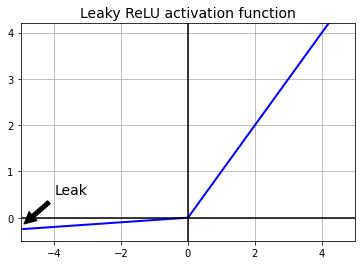

In [3]:
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5, 5, 200)

# LeakyReLU

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

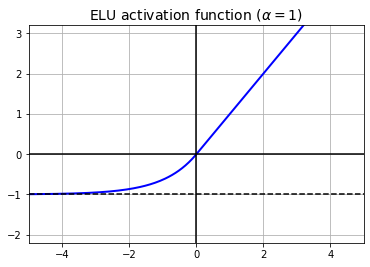

In [4]:
# ELU
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

* LeakyReLU를 사용하려면 LeakyReLU층을 만들고, 모델에서 적용하려는 층 뒤에 추가함.

In [5]:
model = keras.models.Sequential([
    # ...
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2)
    # ...
])

* PReLU를 사용하려면 <code>LeakyReLU</code> 부분을 PReLU로 바꿈. Keras에서는 공식적인 구현은 없음.

* SELU를 사용하려면 층을 만들 때 <code>activation="selu", kernel_initalizer="lecun_normal"</code> 지정.

In [6]:
layer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

* ELU나 다른 ReLU 변종과 함께 He 초기화를 사용하면 훈련 초기화 단계에서는 gradient문제를 감소시킬 수 있음.
* 하지만, 훈련하는 동안 다시 발생하지 않으리라는 보장은 없음.
* 이를 위해 배치 정규화(Batch normalization) 방법 사용.
  * 각 층에서 활성화 함수를 통과하기 전이나 후에 연산을 하나 추가함.
  * 입력을 원점에 맞추고 정규화한 뒤, 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조절하고 이동시킴. 한 파라미터는 스케일 조정에, 나머지 하나는 이동에 사용함.
* 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련 세트를 StandardScaler 등을 사용해 표준화할 필요가 없음.
* 입력 데이터를 원점에 맞추고 정규화하기 위해 평균과 표준편차를 추정해야 함. 이를 위해 현재 미니배치에서 입력의 평균과 표준편차를 평가함.
$$ \boldsymbol{\mu}_B=\frac{1}{m_B}\sum_{i=1}^{m_B}\mathbf{X}^{(i)} $$
$$ \boldsymbol{\sigma}_B^2=\frac{1}{m_B}\sum_{i=1}^{m_B}\left(\mathbf{x}^{(i)}-\boldsymbol{\mu}_B\right)^2 $$
$$ \hat{\mathbf{x}}^{(i)}=\frac{\mathbf{x}^{(i)}-\boldsymbol{\mu}_B}{\sqrt{\boldsymbol{\sigma}_B^2+\epsilon}} $$
$$ \mathbf{z}^{(i)}=\gamma\otimes\hat{\mathbf{x}}^{(i)}+\boldsymbol{\beta} $$
  * $\boldsymbol{\mu}_B$ : 미니배치 B에 대한 입력의 평균 벡터
  * $\boldsymbol{\sigma}_B$ : 미니배치에 대한 입력의 표준편차 벡터
  * $ m_B$ : 미니배치 내의 샘플 수
  * $\hat{\mathbf{x}}^{(i)}$ : 평균이 0이고 정규화된 샘플 i의 입력
  * $\gamma$ : 층의 출력 스케일 파라미터 벡터. $\gamma$와 $\boldsymbol{\beta}$의 차원은 모두 $\mathbf{z}^{(i)}$와 동일. (각 층의 뉴런마다 $\gamma$와 $\boldsymbol{\beta}$를 가진다는 의미.)
  * $\otimes$ : 원소별 곱셈
  * $\boldsymbol{\beta}$ : 층의 출력 이동 파라미터 벡터. 각 입력은 해당 파라미터만큼 이동
  * $\epsilon$ : 분모가 0이 되는 것을 막기 위한 작은 숫자. 안전을 위한 항(smoothing term)이라고 함. 주로 10^-5.
  * $\mathbf{z}^{(i)}$ : 배치 정규화 연산의 출력. 즉, 입력의 스케일을 조정하고 이동시킨 것.

* 훈련하는 동안 입력을 정규화한 다음 스케일을 조정하고 이동시킴.
* 단, 테스트 시에는 여러 샘플로 이루어진 배치가 아닌 하나의 샘플에 대한 예측을 만들어야 하므로 테스트 시의 입력의 평균과 표준편차를 사용할 수 없음.
  * 배치를 사용하더라도 그 크기가 매우 작거나 독립 동일 분포 조건을 만족하지 못할 수 있음.
* 하나의 방법은 훈련이 끝난 후 전체 훈련 세트를 신경망에 통과시켜 배치 정규화 층의 각 입력에 대한 평균과 표준편차를 계산하는 것이 있음. 예측 시 사용한 평균과 표준편차를  최종 입력 평균과 표준편차를 대신 사용할 수 있음.
* <code>BatchNormalization</code>층은 층의 입력 평균과 표준편차의 이동 평균을 사용해 훈련하는 동안 최종 통계를 추정.
  * $\boldsymbol{\gamma}, \boldsymbol{\beta}$는 일반적인 역전파를 통해 학습되고, $\boldsymbol{\mu}(최종\;입력\;평균\;벡터), \boldsymbol{\sigma}(최종\;입력\;표준편차\;벡터$는 지수 평균 이동을 사용해 추정됨. 또한, 훈련하는 동안에 추정되지만 훈련이 끝난 후에 위의 식에서 평균과 표준편차를 대체하기 위해 사용됨.
* 배치 정규화는 모델의 성능을 크게 향상시킴.
  * 그레이디언트 소실 문제가 크게 감소해 tanh나 sigmoid도 사용 가능.
  * 가중치 초기화에 네트워크가 훨씬 덜 민감해짐.
  * 규제와 같은 역할을 하여 다른 규제의 필요성을 줄여줌.
* 단, 배치 정규화는 모델의 복잡도를 키우고, 실행 시간이 느려짐.
  * 훈련이 끝난 후 이전 층과 배치 정규화 층을 합쳐 실행 속도 저하를 피할 수 있음. 이전 층의 가중치를 바꿔 스케일이 조정되고 이동된 출력을 만듦.

In [7]:
# keras에서의 사용은 은닉층의 활성화 함수 전이나 후에 BatchNormalization층을 추가하면 됨.

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_5 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

> * 배치 정규화 층은 입력마다 4개의 파라미터 $\boldsymbol{\gamma}, \boldsymbol{\beta}, \boldsymbol{\mu}, \boldsymbol{\sigma}$를 추가함(ex. 첫 번째 배치 정규화 층에서는 4*784=3136개의 파라미터 존재)
> * $\boldsymbol{\mu}, \boldsymbol{\sigma}$는 역전파로 학습되지 않기 때문에 Non-trainable params로 분류.

In [9]:
# 첫 번재 배치 정규화 층.
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

* 배치 정규화 층은 활성화 함수 이후보다 활성화 함수 이전에 추가하는 것이 좋다고 알려짐. 활성화 함수 이전에 배치 정규화 층을 추가하려면, 은닉층(Dense)에서 활서오하 함수를 지정하지 않고, 배치 정규화 층 뒤에 별도의 층으로 활성화 함수를 추가해야 함.
* 배치 정규화 층은 입력마다 이동 파라미터를 포함하기 때문에 이전 층에서 편향을 뺄 수 있음.(<code>use_bias=False</code>)

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

* <code>BatchNormalization</code>에 조정할 하이퍼파라미터는 기본값으로도 보통 잘 동작하지만, <code>momentum</code> 매개변수(지수 이동 편균을 업데이트할 때 사용하는 값. $\hat{\mathbf{v}}\leftarrow \hat{\mathbf{v}}\times\text{momentum}+\mathbf{v}\times(1-\text{momentum})$ )는 조정하기도 함. 일반적으로는 1에 가까운 값.
  * 데이터셋이 크고 미니배치가 크면 모멘텀 값을 0.99...9와 같이 9를 더 넣어 1에 더 가깝게 만듦.
* <code>axis</code>매개변수는 정규화할 축을 결정. 기본값은 -1. (다른 축을 따라 계산한 평균과 표준편차를 이용해 마지막 축을 정규화함.)
  * 입력 배치가 2차원(샘플 개수*특성 개수)이라면 각 입력 특성이 배치 내의 모든 샘플에 대해 계산한 평균과 표준편차를 기준으로 정규화.
  * 위의 예시에서 첫 번쨰 배치 정규화 층은 784개의 입력 특성마다 독립정으로 정규화됨. 배치 정규화 층을 Flatten층 이전으로 옮기면 입력 배치는 샘플 개수\*높이\*너비 크기의 3차원이 되므로 배치 정규화 층은 28개의 평균과 28개의 표준편차 계산하고 동일한 평균과 표준편차를 이용해 모든 픽셀을 정규화함.
* 배치 정규화는 훈련하는 동안에는 배치 통계를 사용하고, 훈련이 끝난 뒤에는 최종 통계를 사용함.

In [ ]:
# 내부 코드

class BatchNormalization(keras.layers.layer):
    # ...
    def call(self, inputs, training=None):
        # ...

> * call 내에서 실제 계산 수행. fit()은 훈련하는 동안 call의 training 매개변수를 1로 설정. 훈련과 테스트에 대해 다르게 동작하는 층을 만들려면 call()에 training 매개변수를 추가하여 어떤 것을 계산할 지 결정.

* 배치 정규화가 널리 사용되면서 거의 모든 층 뒤에 배치 정규화를 사용하고, 신경망 그림에는 이를 제외해서 그리는 경우도 많음.

* 그레이디언트 폭주 문제를 완화하는 또 다른 방법은 역전파될 때 일정 임곗값을 넘지 못하게 gradient를 잘라내는 방법이 있고, 이를 그레이디언트 클리핑(gradient clipping)이라고 함.

In [12]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

> * gradient 벡터의 모든 원소를 -1.0과 1.0 사이로 클리핑. 즉, 훈련되는 각 파라미터에 대한 손실의 모든 편미분 값을 -1.0에서 1.0으로 잘라냄.
* 임곗값은 하이퍼파라미터로 튜닝 가능.

### 사전 훈련된 층 재사용

* 큰 규모의 신경망을 새로 훈련하는 것은 힘드므로, 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있다면 해당 신경망의 하위층을 재사용하는 것이 좋고, 이를 전이 학습(transfer learning)이라고 함.
  * 훈련 속도를 높여주고 필요한 훈련 데이터도 줄여줌.
  * ex) 카테고리 100개로 구분된 이미지를 분류하도록 훈련된 DNN이 있고, 자동차 종류를 구체적으로 분류하는 DNN을 만들려고 할 때, 카테고리 분류 DNN의 하위 층 일부를 재사용하는 것이 좋을 수 있음.
  * 새로운 작업에 유용한 고수준 특성은 원본 작업의 특성과는 다르므로 상위 은닉층은 하위 은닉층보다는 덜 유용함.
  * 작업이 비슷할 수록 가져올 하위 층의 개수를 늘리는 것이 좋음.
* 전이 학습을 사용하려면 재사용하려는 층을 모두 동결(경사 하강법으로 가중치가 바뀌지 않도록 훈련되지 않는 가중치로 만듦)하고 모델을 훈련한 뒤 성능을 평가함. 그 뒤, 맨 위에 있는 한 두개의 은닉층의 동결을 해제하고 역전파를 통해 가중치를 조절하여 성능이 향상되는지 확인.
  * 훈련 데이터가 많다면 동결 해제할 층을 늘릴 수 있음.
  * 재사용하는 층의 동결을 해제할 때는 학습률을 줄여 가중치를 세밀하게 튜닝하는 게 좋음.
  * 여전히 성능이 좋지 않거나 훈련 데이터가 적다면 상위 은닉층을 제거하고 남은 은닉층을 다시 동결하는 식으로 재사용할 은닉층의 적절한 개수를 찾을 때 까지 반복할 수 있음.

* ex) fashion_mnist 데이터셋 훈련
  * model A(model_fashion)은 "Sandal", "Shirt" 레이블이 붙은 데이터를 제외하고 훈련시킨 모델. model B는 "Sandal", "Shirt"를 구분하느 모델(shirt면 양성, sandal이면 음성)
  * model A의 은닉층을 재사용하여 model B에 사용
  * model B의 훈련 데이터셋은 200개만 존재.
* **참고만 할 것**. 이유 후술

In [34]:
fashoin_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashoin_mnist.load_data()

# model A에 쓸 데이터셋 준비
X_train_removed = X_train_full[np.logical_and(y_train_full!=5, y_train_full!=6)] / 255.0
y_train_removed = y_train_full[np.logical_and(y_train_full!=5, y_train_full!=6)]
X_test_removed = X_test[np.logical_and(y_test!=5, y_test!=6)] / 255.0
y_test_removed = y_test[np.logical_and(y_test!=5, y_test!=6)]

In [52]:
# model B에 쓸 데이터셋 준비
X_train_forB = X_train_full[np.logical_or(y_train_full==5, y_train_full==6)] / 255.0
y_train_forB = y_train_full[np.logical_or(y_train_full==5, y_train_full==6)]
X_test_forB = X_test[np.logical_or(y_test==5, y_test==6)] / 255.0
y_test_forB = y_test[np.logical_or(y_test==5, y_test==6)]

In [53]:
# model B에 쓸 데이터셋 중, 200개만 사용.
X_train_forB = X_train_forB[:200]
y_train_forB = y_train_forB[:200]

In [54]:
for i in range(len(y_train_forB)):
    if y_train_forB[i] == 5:
        y_train_forB[i]=0
    else:
        y_train_forB[i]=1

In [71]:
for i in range(len(y_test_forB)):
    if y_test_forB[i] == 5:
        y_test_forB[i]=0
    else:
        y_test_forB[i]=1

In [22]:
# class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sneaker", "Bag", "Ankle boot"]

In [23]:
for i in range(len(y_train_removed)):
    if y_train_removed[i]>=7:
        y_train_removed[i]-=2
        
for i in range(len(y_test_removed)):
    if y_test_removed[i]>=7:
        y_test_removed[i]-=2

In [16]:
y_train_removed[3]

3

In [24]:
# model A
model_fashion = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(8, activation="softmax"),
])

In [18]:
model_fashion.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 808       
Total params: 266,408
Trainable params: 266,408
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_fashion.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [26]:
history = model_fashion.fit(X_train_removed, y_train_removed, epochs=30)

Epoch 1/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4984 - accuracy: 0.8432
Epoch 2/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3178 - accuracy: 0.8927
Epoch 3/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2901 - accuracy: 0.9030
Epoch 4/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2725 - accuracy: 0.9092
Epoch 5/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2606 - accuracy: 0.9136
Epoch 6/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2509 - accuracy: 0.9170
Epoch 7/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2414 - accuracy: 0.9190
Epoch 8/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2342 - accuracy: 0.9213
Epoch 9/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2275 - accuracy: 0.9229
Epoch 10/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.222

In [28]:
# model A의 정확도는 약 93%
model_fashion.evaluate(X_test_removed, y_test_removed)

250/250 [==============================] - 1s 2ms/step - loss: 0.2067 - accuracy: 0.9270


[0.20669692754745483, 0.9269999861717224]

In [32]:
# 기존 모델 복제 및 가중치 복사

model_A = keras.models.clone_model(model_fashion)
model_A.set_weights(model_fashion.get_weights())

In [33]:
# 출력 층을 제외한 모든 층 재사용 및 새로운 출력층 추가.

model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [61]:
# 작업 B(셔츠, 샌들 분류)를 위해 훈련. 단, 새로운 출력층이 랜덤하게 초기화되어있으므로, 큰 오차 그레이디언트가 재사용된 가중치를 망칠 수 있음. 따라서 처음 몇 번의 epoch동안에는 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 줌.

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

> 층을 동결하거나 동결을 해제했다면 그 다음에는 반드시 모델을 컴파일해야 함.

In [66]:
# 몇 에포크 동안 모델을 훈련한 뒤, 재사용된 층의 동결을 해제하고 훈련을 계속함.
# 동결 해제 이후에는 학습률을 낮춰 재사용된 가중치가 망가지는 것을 막아주는 게 좋음.

history = model_B_on_A.fit(X_train_forB, y_train_forB, epochs=10)

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(lr=1e-4)   #기본값은 1e-2

model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model_B_on_A.fit(X_train_forB, y_train_forB, epochs=20)

Epoch 1/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1017 - accuracy: 0.9950
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0995 - accuracy: 0.9950
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0973 - accuracy: 0.9950
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0955 - accuracy: 0.9950
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0935 - accuracy: 0.9950
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9950
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9950
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0888 - accuracy: 0.9950
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0875 - accuracy: 0.9950
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0862 - accuracy: 0.9950
Epoch 1/20


d:\pythonenv\mlenv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


7/7 [==============================] - 1s 2ms/step - loss: 0.0852 - accuracy: 0.9950
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.0852 - accuracy: 0.9950
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0851 - accuracy: 0.9950
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0851 - accuracy: 0.9950
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0850 - accuracy: 0.9950
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0849 - accuracy: 0.9950
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0849 - accuracy: 0.9950
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0848 - accuracy: 0.9950
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0848 - accuracy: 0.9950
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0847 - accuracy: 0.9950
Epoch 11/20
7/7 [==============================] -

In [72]:
# 정확도 99.6%
model_B_on_A.evaluate(X_test_forB, y_test_forB)

63/63 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9960


[0.06825259327888489, 0.9959999918937683]

> * 단, 위의 예시는 높은 성능을 가진 모델을 찾기 까지 여러 설정을 시도해 본 것이므로, 타깃 클래스나 랜덤 초깃값을 바꾸면 성능이 떨어지게 됨.(즉, 위처럼 해야만 성능이 높게 나오는 것이고, 위의 예시는 참고용으로만 제작.)
> * 논문들에서 신경망을 다룰 때 결과가 너무 긍정적인 이유는 주로 가장 좋은 결과만을 표시하기 때문이므로 주의해야 함.

* 전이 학습은 작은 완전 연결 네트워크에는 잘 동작하지는 않음.
* 주로 일반적인 특성을 감지하는 경향이 있는 심층 합성곱 신경망에서 잘 동작함.

* 레이블된 훈련 데이터가 많지 않은 경우에, 비슷한 작업에 대한 훈련된 모델도 없는 경우, 비지도 사전훈련(unsupervised pretraining)을 사용할 수 있음.
  * 레이블이 없는 데이터를 모으는 것은 쉽지만, 이에 레이블을 부여하는 작업은 많은 비용이 듦.
  * 레이블되지 않은 훈련 데이터를 많이 모을 수 있다면 이를 이용해 autoencoder, 생성적 적대 신경망과 같은 비지도 학습 모델을 훈련할 수 있음. 이후 해당 모델의 하위층을 재사용하고, 그 위에 새 작업에 맞는 출력층을 추가해 지도 학습으로 최종 네트워크를 세밀하게 튜닝하는 방법을 사용할 수 있음.
* 딥러닝 초기에는 탐욕적 층 단위 사전훈련(greedy layer-wise pretraining) 사용. 하나의 층을 가진 비지도 학습 모델을 훈련한 뒤, 이 층을 동결하고 새 층을 추가한 뒤 다시 훈련. 이후 층을 동결하고 새 층을 추가하여 훈련하는 작업을 반복한 뒤 최종적으로 지도 학습을 진행.

* 레이블된 훈련 데이터가 많지 않은 경우 또 다른 방법은 레이블된 훈련 데이터를 쉽게 얻거나 생성할 수 있는 보조 작업에서 첫 번째 신경망을 훈련한 뒤, 해당 신경망의 하위 층을 재사용하는 방법이 있음.
  * ex) 얼굴 인식 시스템을 만들려고 하는데 개인별 이미지가 얼마 없다면, 인터넷에서 무작위로 많은 인물의 이미지를 수집해 두 개의 다른 이미지가 같은 사람의 것인지 감지하는 첫 번째 신경망을 훈련할 수 있고, 해당 신경망은 얼굴의 특성을 잘 감지할 것이므로 하위 신경망을 재사용해 적은 훈련 데이터에서도 얼굴을 잘 구분하는 분류기를 훈련할 수 있음.

### 고속 optimizer

* 심층 신경망의 훈련 속도는 매우 느릴 수 있으므로, 표준적인 경사 하강법 optimizer대신 더 빠른 optimizer를 사용할 수 있음.

#### Momentum

* 완만한 경사를 굴러가는 공이 있다면, 처음에는 느리게 출발하지만, 종단속도에 도달할 때 까지는 빠르게 가속될 것임.
* 이러한 원리를 적용한 것이 모멘텀(Momentum).
  * 일반적인 경사 하강법은 경사면을 따라 일정한 크기의 step으로 조금씩 내려가므로 맨 아래에 도착하는 데 더 오랜 시간이 걸림.
  * 일반적인 경사 하강법은 가중치에 대한 비용 함수 $J(\boldsymbol{\theta})$의 gradient $\nabla_{\theta}J(\boldsymbol{\theta})$에 대해 학습률 $\eta$를 곱한 것을 빼 가중치 $\boldsymbol{\theta}$를 갱신함($\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}-\eta\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$). 즉, gradient가 매우 작으면 속도도 매우 느려짐.
* 모멘텀 최적화는 이전의 gradient가 얼마였는지를 고려하여, 매 반복에서 현재 gradient에 학습룰 $\eta$를 곱한 후, 모멘텀 벡터(momentum vector) $\mathbf{m}$에 더하고, 이 값을 빼는 방식으로 가중치를 계산.
  * 일반적인 경사 하강법은 gradient를 속도로 사용하고, 모멘텀은 가속도로 사용함.
* 일종의 마찰저항을 표현하고, 모멘텀이 너무 커지는 것을 막기 위해 모멘텀(momentum)이라는 하이퍼파라미터 $\beta$를 사용.
  * 보통 0(높은 마찰저항)~1(마찰저항 없음)사이로 설정되고, 일반적으로는 0.9 사용.
$$1.\;\mathbf{m}\leftarrow\beta\mathbf{m}-\eta\nabla_{\theta}\cdot J(\boldsymbol{\theta})$$
$$2.\;\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}+\mathbf{m}$$
* gradient가 일정하면 종단속도(가중치를 갱신하는 최대 크기)는 $\eta$를 곱한 gradient에 $\frac{1}{1-\beta}$를 곱한 것과 같음.
  * ex) $\beta=0.9$라면 종단속도는 gradient\*학습률\*10이 되므로, 일반적인 경사 하강법보다 10배 빠르다는 의미.
* 더 빠르게 평탄한 지역을 탈출하도록 도움.
* 배치 정규화를 사용하지 않는 DNN에서 상위층은 종종 스케일이 매우 다른 입력을 받게 되는데, 모멘텀 최적화를 사용하면 이러한 경우에 큰 도움이 됨.
* 지역 최적점을 건너뛰는 데 도움이 됨.
* 모멘텀 때문에 optimizer가 최적값에 도달하기 전까지 진동하듯이 움직이는데, 이 때문에 마찰저항이 조금 있는 것이 좋음.

In [73]:
# keras에서의 모멘텀 사용. 단순히 SGD optimizer에 momentum 매개변수 지정.
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

d:\pythonenv\mlenv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


* 튜닝할 하이퍼파라미터가 하나 더 늘어나지만, 웬만한 경우 <code>moemntum=0.9</code>에서 잘 작동하며 경사 하강법보다 거의 항상 빠름.

#### 네스테로프 가속 경사(Nesterov accelerated gradient, NAG)

* 모멘텀 최적화의 한 변종.
* 현재 위치가 $\boldsymbol{\theta}$가 아닌, 모멘텀의 방향으로 조금 앞선 $\boldsymbol{\theta}+\beta\mathbf{m}$에서 비용 함수의 gradient 계산.
$$1.\;\mathbf{m}\leftarrow\beta\mathbf{m}-\eta\nabla_{\theta}\cdot J(\boldsymbol{\theta+\beta\mathbf{m}})$$
$$2.\;\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}+\mathbf{m}$$
* 일반 모멘텀 방식보다 네스테로프 방식이 최적값에 조금 더 가까워지고, 모멘텀보다 더 빨리 최적점에 도달할 수 있음.
  * 진동을 감소시키고 수렴을 빠르게 만들어 줌
* SGD optimizer를 만들 떄 <code>use_nesterov=True</code>로 설정하여 사용 가능.

#### AdaGrad

* 한쪽이 길쭉한 그릇 형태에서, 경사 하강법은 전역 최적점 방향으로 바로 향하지 않고, 가장 가파른 경사를 따라 내려가기 시작해 골짜기 아래로 느리게 이동함.
* 이를 일찍 감지하여 전역 최적점 쪽으로 좀 더 정확한 뱡향을 잡게 하는 알고리즘.
  * 가장 가파른 차원을 따라 gradient 벡터의 스케일을 감소시킴.
$$1.\;\mathbf{s}\leftarrow\mathbf{s}+\nabla_{\theta}J(\boldsymbol{\theta})\otimes\nabla_{\theta}j(\boldsymbol{\theta})$$
$$2.\;\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}-\eta\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\oslash\sqrt{\mathbf{s}+\epsilon}$$
  * $\oplus$ : 원소 별 곱셈
  * $\oslash$ : 원소 별 나눗셈
  * 1 : gradient의 제곱을 벡터 $\mathbf{s}$에 누적함. 즉, $\mathbf{s}$의 각 원소 $s_i$마다 $s_i\leftarrow s_i+(\partial J(\boldsymbol{\theta})/\partial\theta_i)^2$을 계산하는 것과 동일($\theta_i$에 대한 비용 함수의 편미분을 제곱하여 누적함). 비용 함수가 i번째 차원을 따라 가파르다면 $s_i$는 반복이 진행되면서 점점 커짐.
  * 2 : 경사 하강법과 비슷하지만, gradient 벡터를 $\sqrt{\mathbf{s}+\epsilon}$으로 나눠 스케일을 조정. $\epsilon$은 0으로 나누는 것을 막기 위한 아주 작은 값.
* 학습률을 감소시키지만, 경사가 완만한 차원보다 가파른 차원에 더 빠르게 감소하고, 이를 적응적 학습률(adaptive learning rate)이라고 함.
  * 차원별로 학습률은 다르게 감소.
  * 전역 최적점으로 더 곧장 가도록 갱신되는 데 도움이 되고, 학습률 파라미터 $\eta$를 덜 튜닝해도 된다는 장점이 있음.
* 간단한 이차방정식 문제에 잘 작동하나, 신경망 훈련 시 학습률이 너무 감소되어 전역 최적점에 도달하기 전에 일찍 멈출 수 있음.
  * keras에서 <code>Adagrad</code>를 사용할 수 있지만, 심층 신경망에서는 사용해선 안됨.

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

#### RMSProp

* 너무 빨리 느려저 전역 최적점에 도달하지 못하는 AdaGrad의 단점을 개선한 것.
* 훈련 시작부터 모든 gradient가 아닌 가장 최근 반복에서 비롯된 gradient만 누적.
  * 알고리즘의 첫 번째 단계에서 지수 감소를 사용함.
$$1.\;\mathbf{s}\leftarrow\beta\mathbf{s}+(1-\beta)\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\otimes\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$$
$$2.\;\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}-\eta\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\oslash\sqrt{\mathbf{s}+\epsilon}$$
* 감쇄율 $\beta$는 주로 0.9로 설정.
  * 이도 조절해야할 하이퍼파라미터이지만, 기본값 0.9일때 대부분의 경우 잘 작동함.
* <code>keras.optimizers.RMSprop(lr=0.001, rho=0.9)</code>와 같이 사용. rho값이 $\beta$값
* 간단한 문제를 제외하고는 항상 AdaGrad보다 성능이 좋음.

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

#### Adam(adaptive moment estimation)

* 모멘텀 최적화와 RMSProp의 아이디어를 합친 것.
* 모멘텀 최적화처럼 지난 gradient의 지수 감소 평균을 따르고, RMSProp처럼 지난 gradient의 제곱의 지수 감소된 평균을 따름.
  * gradient의 평균과 분산에 대한 예측을 함. 평균을 첫 번째 모멘트, 분산을 두 번째 모멘트라고 함.
$$1.\;\mathbf{m}\leftarrow\beta_1\mathbf{m}-(1-\beta_1)\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$$
$$2.\;\mathbf{s}\leftarrow\beta_2\mathbf{s}-(1-\beta_2)\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\otimes\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$$
$$3.\;\hat{\mathbf{m}}\leftarrow\frac{\mathbf{m}}{1-\beta_1^t}$$
$$4.\;\hat{\mathbf{s}}\leftarrow\frac{\mathbf{s}}{1-\beta_2^t}$$
$$5.\;\boldsymbol{\theta}\leftarrow\boldsymbol{\theta}+\eta\hat{\mathbf{m}}\oslash\sqrt{\hat{\mathbf{s}}+\epsilon}$$
  * t는 반복 횟수.
  * 1, 2, 5단계가 모멘텀 최적화 및 RMSProp과 비슷. 대신 1에서 지수 감소 합 대신 지수 감소 평균을 계산.
  * $\mathbf{m},\mathbf{s}$는 처음에 0으로 초기화되기 때문에 훈련 초기에 0쪽으로 치우치게 됨. 3, 4단계가 두 값을 증폭시키는데 도움을 줌. 즉, $\mathbf{m},\mathbf{s}$가 0부터 시작하므로 $\beta_1\mathbf{m}, \beta_2\mathbf{s}$가 반복 초기에 기여를 못하므로, 3,4단계에서 이를 증폭시켜줌. 대신 단계가 많이 진행될수록 3, 4단계의 분모는 1에 가까워져 $\mathbf{m},\mathbf{s}$값이 거의 증폭되지 않음.
* 모멘텀 감쇠 파라미터 $\beta_1$은 주로 0.9로 초기화하고 스케일 감쇠 파라미터 $\beta_2$는 0.999로 주로 초기화함.
* $\epsilon$은 안정적인 계산을 위한 아주 작은 값(10^-7 등.)
  * keras에서 <code>epsilon</code>의 기본값은 None으로, 기본값이 10^-7인 <code>keras.backend.epsilon()</code>을 사용.
  * <code>keras.backend.set_epsilon()</code>을 사용해 바꿀 수 있음.
* 학습률 파라미터 $\eta$를 튜닝할 필요가 적음. 일반적으로는 기본값 0.001을 사용.

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

* AdaMax : Adam의 변종. Adam의 2단계에서 $\mathbf{s}$에 gradient의 제곱을 누적하고(최근 gradient에 더 큰 가중치를 부여하고) 5단계에서 $\epsilon$과 3,4단계를 무시하면 $\mathbf{s}$의 제곱근으로 파라미터 업데이트의 스케일을 낮추게 됨. 즉, 시간이 지남에 따라 감쇠된 gradient의 $l_2$ norm(제곱의 합의 제곱근)으로 파라미터 업데이트의 스케일을 낮춤. AdaMax는 $l_2$ norm을 $l_\infty$로 바꿈. 
  * Adam에서 2단계를 $\mathbf{s}\leftarrow\text{max}\left(\beta_2\mathbf{s},\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\right)$로 바꾸고, 4단계를 삭제한 것이 AdaMax가 됨.
  * 5단계에서 $\mathbf{s}$에 비례해 gradient 업데이트의 스케일을 낮춤.
  * 실전에서 Adam보다 안정적이지만, 데이터셋에 따라 다르고, 일반적으로는 Adam의 성능이 더 좋기 때문에 어떤 작업에서 Adam이 잘 동작하지 않는다면 AdaMax optimizer를 사용할 수 있음.
* Nadam : Adam+네스테로프 기법. Adam보다 조금 더 빠르게 수렴하고, 일반적으로 Adam보다 성능이 좋게 나오지만 때로는 RMSProp이 더 나을때도 있음.

* 위의 모든 최적화 기법들은 1차 편미분(야코비안)에만 의존함.
* 2차 편미분(헤시안) 기반 알고리즘들도 존재하지만, 심층 신경망에는 적용하기 어려움.
  * 하나의 출력마다 n^2개의 2차 편미분을 계산해야 하기 때문(n은 파라미터 개수)
  * 심층 신경망은 수만 개의 파라미터를 가지므로 메모리 용량을 초과할 수 있고, 가능하더라도 시간이 매우 오래 걸림.

* 모든 최적화 알고리즘은 대부분의 파라미터가 0이 아닌 밀집(dense) 모델을 만듦. 이 대신에, 매우 빠르게 실행할 모델이 필요하거나 메모리를 적게 차지하는 모델이 필요하면 일부 가중치가 0인 희소(sparse)모델을 만들 수 있음.
  * 보통 때처럼 훈련한 뒤, 작은 값의 가중치를 제거(0으로 만듦)하는 방식으로 만들 수 있음.
  * 또는, $l_1$규제(이후 설명)를 강하게 적용(optimizer가 가능한 한 많은 가중치를 0으로 만들도록 강제).
* 이도 잘 작동하지 않으면, 텐서플로 모델 최적화 툴킷(TF-MOT)을 사용해 훈련하는 동안 반복적으로 연결 가중치를 크기에 맞춰 제거하는 가지치기 API를 제공.
  * https://www.tensorflow.org/model_optimization/

|클래스|수렴 속도|수렴 품질|
|-----|---------|--------|
|SGD  |느림     |좋음     |
|SGD(momentum=...)|보통|좋음|
|SGD(momentum=...,nesterov=True)|보통|좋음|
|Adagrad|빠름   |나쁨(너무 빨리 멈춤)|
|RMSprop|빠름   |보통 또는 좋음|
|Adam|빠름   |보통 또는 좋음|
|Nadam|빠름   |보통 또는 좋음|
|AdaMax|빠름   |보통 또는 좋음|

### 학습률 스케줄링

* 학습률을 너무 크게 잡으면 훈련이 발산할 수 있고, 너무 작게 잡으면 최적점에 수렴하는 데 매우 오랜 시간이 걸림.
* 컴퓨터 자원이 한정적이라면 차선의 솔루션을 만들기 위해 모델이 완전히 수렴하기 전에 훈련을 멈춰야 함.
  * 이렇게 찾은 약간 높은 학습률은 처음에는 매우 빠르게 수렴하는 방향으로 진행하지만, 최적점 근처에서는 요동이 심해져 수렴하지 못하게 됨.
* 매우 작은 값에서 시작해 매우 큰값까지 지수적으로 학습률을 중가시키며 모델 훈련을 수백번 반벅하여 좋은 학습률을 찾을 수 있음. 이후 학습 곡선을 보고 다시 상승하는 곡선보다 조금 더 작은 학습률을 선택한 뒤, 모델을 다시 초기화하고 이 학습률로 훈련.
* 이 방법 대신, 큰 학습률로 시작해 학습 속도가 느려지면 학습률을 낮추는 방식을 사용할 수 있음. 이런 전략을 학습 스케줄(learning schedule)이라고 함.
  * 최적의 고정 학습률보다 좋은 솔루션을 더 빨리 발견할 수 있음.
  * 거듭제곱 기반 스케줄링 : 학습률을 반복 횟수 t에 대한 함수 $\eta(t)=\eta_0 / (1+t/s)^c$로 설정. $\eta_0$는 초기 학습률, c는 거듭제곱 수(일반적으로 1), s는 step 횟수로, 이들 모두 하이퍼파라미터. 학습률은 각 step마다 감소되고 s번의 step뒤에 학습률은 $\eta_0/2$로 줄어듦. s번마다 step을 반복할수록 학습률은 $\eta_0/3$, $\eta_0/4$...와 같이 줄어듦. 즉, 처음에는 학습률이 빠르게 감소하다가 나중에는 점점 더 느리게 감소함. $\eta_0,s$,(아마 c도) 튜닝해야 제대로 작동함.
  * 지수 기반 스케줄링 : 학습률을 $\eta(t)=\eta_00.1^{t/s}$로 설정. s step마다 10배씩 학습률이 줄어듦. 거듭제곱 기반 스케줄링은 학습률을 갈수록 천천히 감소시키지만, 지수 기반 스케줄링은 매 스텝마다 10배씩 계속 감소함.
  * 구간별 고정 스케줄링 : 일정 횟수의 epoch동안 일정한 학습률을 사용하고, 그다음 또 다른 횟수의 epoch동안 작은 학습률을 사용하는 식으로 스케줄링. 잘 동작할 수 있지만, 적절한 학습률과 epoch횟수의 조합을 찾는 것이 힘듦.
  * 성능 기반 스케줄링 : 조기 종료처럼 매 N step마다 검증 오차를 측정하고 오차가 줄어들지 않으면 $\lambda$배만큼 학습률을 감소시킴.
  * 1cycle 스케줄링 : 훈련 절반 동안 초기 학습룰 $\eta_0$을 선형적으로 $\eta_1$까지 증가시킨 뒤, 나머지 절반 동안 선형적으로 학습률을 다시 $\eta_0$까지 줄임. 마지막 몇 epoch는 학습률을 소수점 몇 번재 자리까지 선형적으로 줄임. 최대 학습률 $\eta_1$은 최적의 학습률을 찾을 때와 같은 방식을 이용해 선택하고, 초기 학습률 $\eta_0$는 이보다 10배정도 낮은 값을 사용함.
    * 모멘텀 사용 시 처음에 높은 모멘텀(ex. 0.95)으로 시작해 훈련의 처음 절반 동안 낮은 모멘텀으로 줄어듦(ex. 0.85). 이후 나머지 절반동안 최댓값(ex. 0.95)으로 되돌리고 마지막 몇 epoch는 최댓값을 유지한 채로 진행.
    * 훈련 속도를 크게 높여주고 더 높은 성능을 낼 수 있음.

In [ ]:
# 거듭제곱 기반 스케줄링(구현이 가장 쉬움)

optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

> * <code>decay</code> : s의 역수. 기본값은 0이고, Adagrad, RMSProp, Adam, Adamax도 동일한 decay 매개변수를 지원함.
> * keras에서 c는 1로 가정.

In [ ]:
# 지수 기반 스케줄링

# 현재 epoch를 받아 학습률을 반환하는 함수 정의
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch/20)

# 또는 eta_0와 s를 하드코딩하지 않고 이 변수를 설정한 closure를 반환하는 함수를 만들 수도 있음.
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

# 이후 이 스케줄링 함수를 전달해 LearningRateScheduler 콜백을 만든 뒤, fit()메서드에 전달
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, callbacks=[lr_scheduler])

> * <code>LearningRateScheduler</code>는 epoch를 시작할 때 마다 optimizer의 learning_rate 속성을 업데이트함. 더 자주 업데이트 하고싶다면(ex. 매 step마다 업데이트) 사용자 정의 콜백을 만들 수 있음.
>   * epoch마다 step이 많다면 스텝마다 학습률을 업데이트하는 것이 좋음.

In [ ]:
# 스케줄 함수는 두 번쨰 매개변수(현재 학습률)도 받을 수 있음.

# 이전 학습률에 0.1^(1/20)을 곱해 동일한 지수 감쇠 효과를 내는 스케줄 함수
def exponential_decay_fn(epoch, lr):
    return lr*0.1**(1/20)

* 모델 저장 시 optimizer와 학습률이 같이 저장됨. 
* 새로운 스케줄 함수를 사용하더라도 훈련된 모델을 불러와 중지된 지점부터 훈련을 계속할 수 있음.
  * 단, 스케줄 함수가 epoch매개변수를 사용한다면, 이는 저장되지 않고 fit()을 호출할 때 마다 0으로 초기화됨(중지된 지점에서 모델 훈련을 이어가면 매우 큰 학습률이 만들어질 수 있기 때문).
  * 이를 해결하기 위해 epoch에서 시작하도록 fit()의 매개변수 <code>initial_epoch</code>를 수동으로 지정할 수 있음.

In [ ]:
# 구간별 고정 스케줄링
# 지수 기반 스케줄링과 동일하게 스케줄 함수로 LearningRateScheduler콜백을 만들어 fit()에 전달하는 방식으로 사용.

def piecewise_constant_fn(epoch):
    if epoch<5:
        return 0.01
    elif epoch<15:
        return 0.005
    else:
        return 0.001
    
# 또는 좀 더 일반적인 함수를 정의할 수 있음
"""
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])
"""

In [ ]:
# 성능 기반 스케줄링
# ReduceLROnPlateau콜백을 사용.

# 최상의 검증 손실이 5번의 연속적인 epoch동안 향상되지 않을 때 마다 학습률에 0.5를 곱함
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

* keras에서는 <code>keras.optimizers.schedules</code>에 있는 스케줄 중 하나를 사용해 학습률을 정의하고, 이 학습률을 optimizer에 전달할 수 있음. 이렇게 하면 매 epoch가 아닌, 매 스텝마다 학습률을 업데이트함.
  * 간결하고 이해하기 편함
  * 모델 저장 시 학습률과 현재 상태를 포함한 스케줄도 함께 저장됨
  * 단, 표준 keras api는 아니며 tf.keras에서만 지원

In [ ]:
# 지수 기반 스케줄링
s = 20 * len(X_train) // 32 # 20번 epoch에 담긴 전체 step 수. 배치 크기는 32
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

* 1 cycle 방식은 매 반복마다 학습률을 조정하는 사용자 정의 콜백을 만들어 사용 가능.
  * <code>self.model.optimizer.lr</code>(또는 <code>self.model.optimizer.learning_rate</code>)을 바꿔 optimizer의 학습률을 업데이트할 수 있음.

* 지수 기반 스케줄링, 성능 기반 스케줄링, 1cycle 스케줄링이 수렴 속도를 크게 높일 수 있음.
> 최근 연구에는 SGD, 모멘텀, 네스테로프 가속 경사 등에서 학습률 감소 대신 배치 크기를 늘리는 것으로 같은 효과를 낼 수 있다고도 함.

### 규제

* 과대적합을 피하는 데 사용함.
* 심층 신경망은 파라미터가 매우 많으므로 자유도가 매우 높음. 즉, 대규모의 복잡한 데이터셋을 학습할 수 있음.
* 그러나, 자유도가 높으면 훈련 세트에 과대적합될 수 있으므로 규제를 사용해야 함.
* 조기 종료, 배치 정규화 등이 규제 방법으로 사용하고, 그 외에 $l_1$ 및 $l_2$규제, dropout, max-norm규제가 있음.

#### $l_1, l_2$ 규제

* 연결 가중치를 제한하기 위해 $l_2$규제를 사용하거나, 많은 가중치가 0인 희소 모델을 만들기 위해 $l_1$규제를 사용할 수 있음.

In [ ]:
layer = keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01))   # 규제 강도가 0.01인 l2규제 사용

* <code>l2</code>함수는 훈련하는 동안 규제 손실을 계산하기 위해, 각 step에서 호출되는 규제 객체를 반환하고, 이 손실은 최종 손실에 합산됨.
* $l_1$규제가 필요하면 <code>keras.regularizers.l1()</code>을 사용할 수 있고, l1과 l2둘 다 필요하다면 <code>regularizers.l1_l2(l1=..., l2=...)</code>와 같이 사용.
* 일반적으로 모든 은닉층에 동일한 활성화 함수, 초기좌 전략, 규제를 적용하기 때문에 반복문을 사용하도록 refactoring하거나 <code>functools.partial()</code> 함수를 사용해 기본 매개변수 값을 사용하여 함수 호출을 감쌀 수 있음.

In [2]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax", kernel_initializer="glorot_uniform")
])

#### Dropout

* 가장 인기 있는 규제 기법 중 하나. 대부분의 경우에서 정확도의 상승을 기대할 수 있음.
* 매 훈련 step마다 각 뉴런(입력 뉴런은 포함하고, 출력 뉴런은 제외)이 드랍아웃될 확룰 $p$를 가짐. 즉, $p$라는 확률에 따라 각 훈련 step에서 뉴런은 무시될수도 있고, 활성화될수도 있음.
  * 하이퍼파라미터 $p$는 드롭아웃 비율(dropout rate)이라고 하고, 주로 10%~50%사이를 지정함.
  * 순환 신경망에서는 20~30%, CNN에서는 40~50% 사용.
* 훈련이 끝난 뒤에는 dropout을 적용하지 않음.
* 드랍아웃으로 훈련된 뉴런은 이웃한 뉴런에 맞추어 적응되지 않고, 각각의 뉴런 자기 자신이 유용해지게 됨. 또한, 몇 개의 입력 뉴런에만 지나치게 의존하지 않고 모든 입력 뉴런에 주의를 기울이게 됨. 이는 입력의 작은 변화에 덜 민감해지게 되어 안정적인 네트워크를 만들어주고, 일반화 성능이 좋아짐.
* 또한, 각 훈련 step에서 unique한 네트워크가 생성된다고 생각할 수 있음.
  * 드랍아웃이 가능한 뉴런 수가 N개라면 $2^N$개의 unique한 네트워크가 생길 수 있고, 이 수는 매우 크므로 동일한 네트워크가 선택될 가능성이 매우 낮음.
  * 이 신경망은 대부분의 가중치를 공유하고 있어 아주 독립적이진 않음에도 형태가 모두 다르므로 결과적으로 만들어진 신경망은 모든 신경망을 평균한 앙상블로 볼 수 있음.
* 일반적으로 출력층을 제외하고 맨 위의 층부터 세 번째 층까지 있는 뉴런에만 드랍아웃을 적용함.
* $p=50\%$일 때, 테스트하는 동안에는 하나의 뉴런이 훈련 때보다 평균적으로 두 배 많은 입력 뉴런과 연결된다(테스트할 때는 드롭아웃을 적용하지 않으므로). 이를 보상하기 위해 훈련 뒤에는 각 뉴런의 연결 가중치에 0.5를 곱할 필요가 있음. 그렇지 않으면 각 뉴런이 훈련 시 보다 두배 많은 입력 신호를 받기 때문에 잘 동작하지 않을 수 있음.
  * 일반적으로 표현하면 훈련이 끝난 뒤, 각 입력의 연결 가중치에 보존 확률(keep probability) $1-p$를 곱하거나, 훈련하는 동안 각 뉴런의 출력을 보존 확률로 나눌 수 있음.

In [3]:
# keras에서의 드롭아웃 구현. keras.layers.Dropout층을 사용
#   훈련하는 동안 일부 입력을 랜덤하게 버림(0으로 만듦). 그 뒤 남은 입력을 보존 확률로 나눔.
#   훈련이 끝난 뒤에는 입력을 그대로 출력으로 전달함.
#   Dropout층 이전의 층의 출력을 입력으로 받아 확률에 따라 그 일부를 dropout함.

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

* 드롭아웃은 훈련하는 동안에만 활성화되므로 훈련 손실과 검증 손실이 다르게 나올 수 있음. 따라서 훈련이 끝난 후 드롭아웃을 빼고 훈련 손실을 평가해야 함.
* 모델이 과대적합되면 드롭아웃 비율을 늘릴 수 있고, 과소적합되면 드롭아웃 비율을 낮춰야 함.
* 또한, 층이 클 때는 드롭아웃 비율을 늘리고 작은 층에는 드롭아웃 비율을 낮추는 것이 좋음.
* 최근의 많은 신경망 구조는 마지막 은닉층 뒤에만 드롭아웃을 사용함(드롭아웃을 전체에 사용하는 것이 너무 강할 때 사용).
* 드롭아웃은 수렴을 상당히 느리게 만들지만, 적절히 튜닝하면 훨씬 좋은 모델을 만듦.
> SELU 활성화 함수를 기반으로 한 자기 정규화 네트워크를 규제하려면 alpha dropout(https://arxiv.org/pdf/1706.02515.pdf, New Dropout Technique)을 사용해야 함.

#### 몬테 카를로 드롭아웃
* 훈련된 드롭아웃 모델을 재훈련하거나 수정하지 않고 성능을 향상시킬 수 있는 방법.
* 드롭아웃을 활성화한 상태로 여러 개의 예측을 만들어 예측 결과를 평균함.
* 드롭아웃 모델의 성능을 높여주고 더 정확한 불확실성 추정을 제공함.
  * 훈련하는 동안은 일반적인 드롭아웃과 동일하므로 규제처럼 작동.

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

In [36]:
fashoin_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashoin_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.0

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [37]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [38]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3931 - accuracy: 0.8535 - val_loss: 0.3310 - val_accuracy: 0.8786
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3892 - accuracy: 0.8567 - val_loss: 0.3295 - val_accuracy: 0.8822
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3914 - accuracy: 0.8554 - val_loss: 0.3349 - val_accuracy: 0.8784
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3873 - accuracy: 0.8559 - val_loss: 0.3263 - val_accuracy: 0.8800
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3861 - accuracy: 0.8571 - val_loss: 0.3248 - val_accuracy: 0.8814
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3884 - accuracy: 0.8566 - val_loss: 0.3243 - val_accuracy: 0.8798
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3833 - accuracy: 0.8580 - val_loss: 0.3246 - val_accuracy:

In [39]:
y_probas = np.stack([model(X_test,  training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

> * <code>model(X)</code> : <code>model.predict(X)</code>와 비슷. 단, tensor를 반환함.
> * <code>training=True</code> 로 지정했기 때문에 Dropout층이 활성화되어 예측이 달라짐.
> * test set으로부터 100개의 예측을 만들어 쌓음. 모델을 호출할 때 마다 샘플이 행이고, 클래스마다 하나의 열을 가진 행렬이 반환됨. 즉, test set에 10000개의 샘플과 10개의 클래스가 있으므로 행렬의 크기는 [10000, 10]이 됨. 이를 100개 쌓았기 때문에 y_probas는 [100, 10000, 10]크기가 됨.
> * <code>.mean(axis=0)</code>은 첫 번재 차원을 기준으로 평균을 냄. 결과로 나온 y_proba의 크기는 [10000, 10]

* 위처럼 드롧아웃으로 만든 예측들을 평균하면 드롭아웃 없이 예측한 하나의 결과보다 더 안정적으로 나옴.

In [58]:
# dropout없이 예측한 결과
pred = np.round(model.predict(X_test[:1]), 2)

In [59]:
pred

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.13, 0.  , 0.84]],
      dtype=float32)

In [60]:
class_names[np.argmax(pred)]

'Ankle boot'

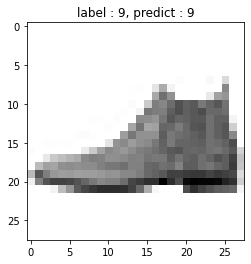

In [62]:
import matplotlib.pyplot as plt
plt.title(f"label : {y_test[:1][0]}, predict : {np.argmax(pred)}")
plt.imshow(X_test[:1][0], cmap="binary")

In [63]:
# dropout을 활성화한 상태에서의 여러 예측
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.23, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.13, 0.02, 0.76]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.03, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.07, 0.  , 0.91]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.12, 0.  , 0.86]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.51, 0.  , 0.16, 0.  , 0.33]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 0.  , 0.05, 0.  , 0.56]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.18, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.11, 0.  , 0.86]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.05, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.09, 0.  , 0.82]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.02, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.42, 0.  , 0

> * dropout을 끈 상태에서 모델은 첫 번째 test set 데이터에 대해 84%의 확률로 ankle boot라고 예측
> * dropout을 활성화한 상태에서는 끈 상태보다 ankle boot라는 예측을 좀 더 약하게 함.
>   * 신발이라는 공통점을 가진 라벨인 샌들(5)과 스니커즈(7)로 예측하기도 함.

In [64]:
# y_probas를 평균낸 결과.
# dropout없이 예측한 결과보다 확신을 덜 함.(71%)

np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.17, 0.  , 0.71]],
      dtype=float32)

In [66]:
# 확률 추정의 표준 분포 확인

y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.15, 0.  , 0.18]],
      dtype=float32)

In [67]:
# 드롭아웃이 적용된 예측으로 정확도 출력
y_pred = np.argmax(y_proba, axis=1)
np.sum(y_pred == y_test) / len(y_test)

0.8691

* 의료 및 금융 서비스 등 위험에 민감한 시스템을 만들 때 불확실한 예측을 주의깊게 다뤄야 함.
  * 드롭아웃을 적용하지 않은 예측과 같은 높은 확신을 가진 예측으로 다루어서는 안됨.
* 몬테 카를로 샘플의 숫자(위에서는 100개)는 튜닝 가능.
  * 값이 높을수록 예측과 불확실성 추정이 정확해지지만, 수가 두 배로 늘어나면 예측 시간도 두 배로 늘어남.
  * 또한, 일정 수 이상 넘어가면 성능 향상이 크지 않음.
* <code>BatchNormalization</code>층과 같이 모델이 훈련하는 동안 다르게 작동하는 층이 있다면 훈련 모드를 강제로 설정하면 안 됨.
  * <code>Dropout</code>층을 아래와 같은 <code>MCDropout</code>로 바꿔 해결가능.

In [68]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

> * <code>Dropout</code>을 상속해 <code>call()</code>을 오버라이드하여 training 매개변수를 강제로 True로 설정
> * 모든 keras API에서 사용가능.

#### Max-Norm 규제

* 각 뉴런에 대한 입력 연결 가중치 $\mathbf{w}$가 $\parallel\mathbf{w}\parallel_2\leq r$이 되도록 제한.
  * r은 max-norm 하이퍼파라미터이고, $\parallel\;\parallel_2$는 $l_2$ norm
* 전체 손실 함수에 규제 손실 항을 추가하지 않고 매 훈련 스텝이 끝날 때 $\parallel\mathbf{w}\parallel_2$를 계산하고 필요하면 $\mathbf{w}$의 스케일을 조정함($\displaystyle\mathbf{w}\leftarrow\mathbf{w}\frac{r}{\parallel\!w\!\parallel_2}$)
* r을 줄이면 규제의 양이 커져 과대적합을 감소시킬 수 있음.
* 불안정한 gradient문제를 완화하는 데 도움.

In [69]:
# keras에서의 max-norm 규제 사용
# 적절한 최댓값으로 지정한 max_norm()이 반환한 객체로 은닉층의 kernel_constraint 매개변수 지정

keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", kernel_constraint=keras.constraints.max_norm(1.))

* 매 훈련 반복이 끝난 후 fit()이 층이 가중치와 함깨 max_norm()이 반환한 객체를 호출하고 스케일이 조정된 가중치를 받음.
* max_norm()에는 axis 매개변수(기본값 0) 존재. Dense층은 보통 [샘플 개수, 뉴런 개수] 크기의 가중치를 가지는데 axis=0를 사용하면 각 뉴런의 가중치 벡터에 독립적으로 적용
  * CNN에서 axis 매개변수를 적절히 조정해야함(<code>axis=[0,1,2]</code>와 같이).

### 정리 및 가이드라인

* 일반적으로 잘 맞는 설정(절대적인 것은 아님.)

|하이퍼파라미터|기본값|
|------------|------|
|커널 초기화|He 초기화|
|활성화 함수 |ELU     |
|정규화      |얕은 신경망-없음, 깊은 신경망-배치 정규화|
|규제        |조기 종료(필요 시 l2 추가)|
|optimizer  |모멘텀, RMSProp, Nadam|
|학습률 스케줄|1cycle|

* 네트워크가 완전 연결 층을 쌓은 단순한 모델이면 자기 정규화 사용 가능. 이런 경우에서의 일반적으로 잘 맞는 설정

|하이퍼파라미터|기본값|
|------------|------|
|커널 초기화|LeCun 초기화|
|활성화 함수 |SELU     |
|정규화      |없음(자기 정규화됨)|
|규제        |알파 드롭아웃(필요 시)|
|optimizer  |모멘텀, RMSProp, Nadam|
|학습률 스케줄|1cycle|

* 입력 특성은 정규화가 필요.
* 비슷한 문제를 해결한 모델을 찾을 수 있다면 사전훈련된 신경망의 일부를 재사용하는 것이 좋음.
* 레이블이 없는 데이터가 많다면 비지도 사전훈련 사용
* 비슷한 작업을 위한 레이블된 데이터가 많다면 보조 작업에서 사전훈련 수행
* 희소 모델이 필요하다면 $l_1$규제를 사용할 수 있음.
  * 매우 희소한 모델이 필요하다면 TF-MOT 사용 가능. 단, 자기 정규화를 깨뜨리므로 위의 일반적으로 잘 맞는 설정을 사용해야 함.
* 빠른 응답을 하는 모델(예측이 매우 빠른 모델)이 필요하다면 층 개수를 줄이고 배치 정규화 층을 이전 층에 합침. 또한, LeakyReLU와 ReLU같이 빠른 활성화 함수를 써도 되고 희소 모델을 만드는 것도 도움이 됨. 부동소수점 정밀도를 낮출 수도 있음.
* 위험에 민감하고 예측 속도가 중요하지 않다면 MC 드롭아웃 사용

-------------------

### ex8

In [47]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
# 100개의 뉴런을 가진 은닉층 20개로 만들어진 심층 신경망
# activation함수는 ELU, 초기화 전략은 He 초기화
RegularizedDense = partial(keras.layers.Dense, activation="elu", kernel_initializer="he_normal")

model_cifar = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [50]:
# CIFAR10 image 데이터셋 로드
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [51]:
# 정규화
X_train_normalized = X_train/255
X_test_normalized = X_test/255

In [52]:
# validation set 분리
from sklearn.model_selection import train_test_split

X_train_normalized, X_valid, y_train, y_valid = train_test_split(X_train_normalized, y_train, test_size=0.1)

In [53]:
# 클래스 별 이름
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

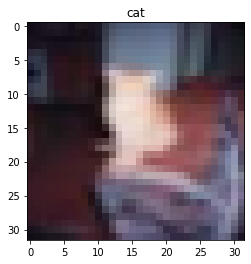

In [54]:
# 0번째 이미지 및 레이블 출력(개구리)
plt.title(class_names[y_train[0][0]])
plt.imshow(X_train_normalized[0])

In [55]:
# 10장에서 사용한 최적의 학습률 찾기
K = keras.backend

class ExponentialLrCallback(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.lr = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.lr.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

keras.backend.clear_session()

In [56]:
# Nadam optimizer 이용, 학습률 1e-5부터 0.5%씩 증가
optimizer = keras.optimizers.Nadam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model_cifar.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

expon_lr = ExponentialLrCallback(1.005)

In [57]:
# 작은 epoch로 fit
history = model_cifar.fit(X_train_normalized, y_train, epochs=5, batch_size=256, callbacks=[expon_lr])

Epoch 1/5
176/176 [==============================] - 7s 24ms/step - loss: 2.3375 - accuracy: 0.1858
Epoch 2/5
176/176 [==============================] - 4s 24ms/step - loss: 1.9856 - accuracy: 0.2794
Epoch 3/5
176/176 [==============================] - 4s 24ms/step - loss: 1.9322 - accuracy: 0.3015
Epoch 4/5
176/176 [==============================] - 4s 24ms/step - loss: 1.9120 - accuracy: 0.3124
Epoch 5/5
176/176 [==============================] - 4s 24ms/step - loss: 1.9771 - accuracy: 0.2904


Text(0, 0.5, 'Loss')

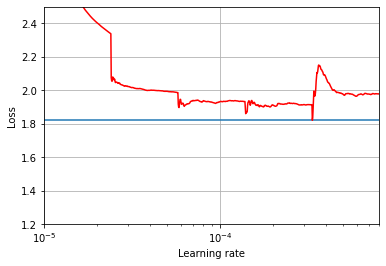

In [58]:
# 학습률에 따른 loss 곡선 출력
plt.plot(expon_lr.lr, expon_lr.losses, 'r-')
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.lr), max(expon_lr.lr))
plt.axis([min(expon_lr.lr), max(expon_lr.lr), 0, expon_lr.losses[0]])
plt.grid()
plt.ylim([1.2, 2.5])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [59]:
# Nadam optimizer의 학습률은 5e-5로 결정.
# 조기 종료 추가, 최선의 모델을 저장하는 체크포인트 추가, 100 epoch
optimizer = keras.optimizers.Nadam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model_cifar.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model_cifar.fit(X_train_normalized, y_train, validation_data=(X_valid, y_valid) ,epochs=100, batch_size=256, callbacks=[keras.callbacks.EarlyStopping(patience=15), keras.callbacks.ModelCheckpoint("cifar_model.h5", save_best_only=True)])

Epoch 1/100
176/176 [==============================] - 9s 28ms/step - loss: 1.6909 - accuracy: 0.3938 - val_loss: 1.6808 - val_accuracy: 0.3906
Epoch 2/100
176/176 [==============================] - 5s 27ms/step - loss: 1.6211 - accuracy: 0.4174 - val_loss: 1.6593 - val_accuracy: 0.3966
Epoch 3/100
176/176 [==============================] - 5s 29ms/step - loss: 1.5817 - accuracy: 0.4326 - val_loss: 1.6155 - val_accuracy: 0.4170
Epoch 4/100
176/176 [==============================] - 5s 28ms/step - loss: 1.5504 - accuracy: 0.4475 - val_loss: 1.5954 - val_accuracy: 0.4198
Epoch 5/100
176/176 [==============================] - 5s 28ms/step - loss: 1.5261 - accuracy: 0.4548 - val_loss: 1.5725 - val_accuracy: 0.4310
Epoch 6/100
176/176 [==============================] - 5s 26ms/step - loss: 1.5035 - accuracy: 0.4617 - val_loss: 1.5705 - val_accuracy: 0.4316
Epoch 7/100
176/176 [==============================] - 5s 27ms/step - loss: 1.4830 - accuracy: 0.4710 - val_loss: 1.5549 - val_accuracy:

In [60]:
# 학습된 모델로 평가
# validation set 정확도 약 50.7%
# test set 정확도 약 51%
model = keras.models.load_model('cifar_model.h5')
model.evaluate(X_valid, y_valid)
model.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4549 - accuracy: 0.4906


[1.4549211263656616, 0.49059998989105225]

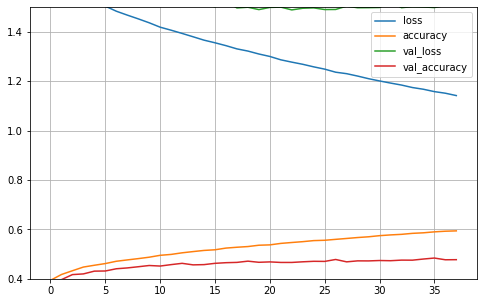

In [61]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0.4, 1.5) # 수직축의 범위 설정
plt.show()

In [62]:
# 각 층마다 배치 정규화 적용
model_cifar_batchnorm = keras.models.Sequential()
model_cifar_batchnorm.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model_cifar_batchnorm.add(keras.layers.BatchNormalization())

for _ in range(20):
    model_cifar_batchnorm.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model_cifar_batchnorm.add(keras.layers.BatchNormalization())
    model_cifar_batchnorm.add(keras.layers.Activation("elu"))
model_cifar_batchnorm.add(keras.layers.Dense(10, activation="softmax"))

In [63]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model_cifar_batchnorm.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history_batchnorm = model_cifar_batchnorm.fit(X_train_normalized, y_train, validation_data=(X_valid, y_valid) ,epochs=100, batch_size=256, callbacks=[keras.callbacks.EarlyStopping(patience=15), keras.callbacks.ModelCheckpoint("cifar_model_batchnorm.h5", save_best_only=True)])

Epoch 1/100
176/176 [==============================] - 19s 53ms/step - loss: 1.8045 - accuracy: 0.3574 - val_loss: 1.7791 - val_accuracy: 0.3860
Epoch 2/100
176/176 [==============================] - 9s 50ms/step - loss: 1.5291 - accuracy: 0.4528 - val_loss: 1.5764 - val_accuracy: 0.4358
Epoch 3/100
176/176 [==============================] - 9s 51ms/step - loss: 1.4381 - accuracy: 0.4896 - val_loss: 1.5274 - val_accuracy: 0.4518
Epoch 4/100
176/176 [==============================] - 9s 50ms/step - loss: 1.3656 - accuracy: 0.5146 - val_loss: 1.5062 - val_accuracy: 0.4680
Epoch 5/100
176/176 [==============================] - 9s 50ms/step - loss: 1.3101 - accuracy: 0.5357 - val_loss: 1.4712 - val_accuracy: 0.4784
Epoch 6/100
176/176 [==============================] - 9s 49ms/step - loss: 1.2621 - accuracy: 0.5538 - val_loss: 1.4796 - val_accuracy: 0.4850
Epoch 7/100
176/176 [==============================] - 9s 50ms/step - loss: 1.2140 - accuracy: 0.5699 - val_loss: 1.4307 - val_accuracy

In [64]:
# 정확도가 조금 더 높고, 적은 epoch만으로 더 빨리 수렴함.
model = keras.models.load_model('cifar_model_batchnorm.h5')
model.evaluate(X_valid, y_valid)
model.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.4097 - accuracy: 0.5016


[1.4097179174423218, 0.5016000270843506]

In [65]:
# selu 활성화 함수를 위한 데이터셋 수정
# 평균 0, 표준편차 1로 만듦.
from scipy import stats
X_train_selu = stats.zscore(X_train_normalized)
X_valid_selu = stats.zscore(X_valid)
X_test_selu = stats.zscore(X_test_normalized)

In [71]:
X_train_selu.mean()

-4.0012733866963876e-14

In [72]:
X_train_selu.std()

0.9999999999999972

In [66]:
# 활성화 함수는 selu, 가중치는 lecun 정규분포 초기화
model_cifar_selu = keras.models.Sequential()
model_cifar_selu.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model_cifar_selu.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_selu.add(RegularizedDense(10, activation="softmax"))

earlystop_callback = keras.callbacks.EarlyStopping(patience=15)
checkpoint_callback = keras.callbacks.ModelCheckpoint("cifar_model_selu.h5", save_best_only=True)
callbacks = [earlystop_callback, checkpoint_callback]

optimizer = keras.optimizers.Nadam(learning_rate=7e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model_cifar_selu.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [67]:
history_selu = model_cifar_selu.fit(X_train_selu, y_train, validation_data=(X_valid_selu, y_valid) ,epochs=100, batch_size=256, callbacks=callbacks)

Epoch 1/100
176/176 [==============================] - 9s 34ms/step - loss: 1.8988 - accuracy: 0.3211 - val_loss: 1.7321 - val_accuracy: 0.3874
Epoch 2/100
176/176 [==============================] - 6s 32ms/step - loss: 1.6481 - accuracy: 0.4143 - val_loss: 1.6956 - val_accuracy: 0.3936
Epoch 3/100
176/176 [==============================] - 6s 33ms/step - loss: 1.5383 - accuracy: 0.4562 - val_loss: 1.6285 - val_accuracy: 0.4284
Epoch 4/100
176/176 [==============================] - 5s 31ms/step - loss: 1.4621 - accuracy: 0.4819 - val_loss: 1.5521 - val_accuracy: 0.4476
Epoch 5/100
176/176 [==============================] - 6s 33ms/step - loss: 1.3926 - accuracy: 0.5062 - val_loss: 1.5280 - val_accuracy: 0.4638
Epoch 6/100
176/176 [==============================] - 5s 31ms/step - loss: 1.3380 - accuracy: 0.5284 - val_loss: 1.5128 - val_accuracy: 0.4764
Epoch 7/100
176/176 [==============================] - 6s 31ms/step - loss: 1.2900 - accuracy: 0.5434 - val_loss: 1.5152 - val_accuracy:

In [68]:
model = keras.models.load_model('cifar_model_selu.h5')
model.evaluate(X_valid_selu, y_valid)
model.evaluate(X_test_selu, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.4438 - accuracy: 0.5065


[1.443793535232544, 0.5065000057220459]

In [92]:
# alpha dropout 사용(selu에서 사용하는 dropout)
model_cifar_alpha = keras.models.Sequential()
model_cifar_alpha.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(17):
    model_cifar_alpha.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_alpha.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_alpha.add(keras.layers.AlphaDropout(0.2))
model_cifar_alpha.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_alpha.add(keras.layers.AlphaDropout(0.2))
model_cifar_alpha.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_alpha.add(keras.layers.AlphaDropout(0.2))
model_cifar_alpha.add(RegularizedDense(10, activation="softmax"))

earlystop_callback = keras.callbacks.EarlyStopping(patience=15)
checkpoint_callback = keras.callbacks.ModelCheckpoint("cifar_model_alpha.h5", save_best_only=True)
callbacks = [earlystop_callback, checkpoint_callback]

optimizer = keras.optimizers.Nadam(learning_rate=5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model_cifar_alpha.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [78]:
history_alpha = model_cifar_alpha.fit(X_train_selu, y_train, validation_data=(X_valid_selu, y_valid) ,epochs=100, batch_size=256, callbacks=callbacks)

Epoch 1/100
176/176 [==============================] - 12s 43ms/step - loss: 2.1640 - accuracy: 0.2622 - val_loss: 1.9302 - val_accuracy: 0.3762
Epoch 2/100
176/176 [==============================] - 7s 39ms/step - loss: 1.7599 - accuracy: 0.3726 - val_loss: 1.7760 - val_accuracy: 0.3956
Epoch 3/100
176/176 [==============================] - 7s 40ms/step - loss: 1.6274 - accuracy: 0.4300 - val_loss: 1.6805 - val_accuracy: 0.4338
Epoch 4/100
176/176 [==============================] - 7s 40ms/step - loss: 1.5443 - accuracy: 0.4575 - val_loss: 1.7173 - val_accuracy: 0.4490
Epoch 5/100
176/176 [==============================] - 7s 40ms/step - loss: 1.4782 - accuracy: 0.4809 - val_loss: 1.7230 - val_accuracy: 0.4506
Epoch 6/100
176/176 [==============================] - 7s 40ms/step - loss: 1.4150 - accuracy: 0.5033 - val_loss: 1.6492 - val_accuracy: 0.4652
Epoch 7/100
176/176 [==============================] - 7s 40ms/step - loss: 1.3672 - accuracy: 0.5240 - val_loss: 1.7240 - val_accuracy

In [79]:
# 학습된 모델에서 드롭아웃을 제거하지 않고 평가하는 몬테 카를로 드롭아웃(MC dropout) 사용
model = keras.models.load_model('cifar_model_alpha.h5')
y_probas = np.stack([model(X_test_selu, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [82]:
y_proba.shape

(10000, 10)

In [89]:
y_pred = np.argmax(y_proba, axis=1)
np.sum(y_pred == y_test.T) / len(y_test)

0.4859

In [102]:
# alpha dropout 사용(selu에서 사용하는 dropout)
model_cifar_1cycle = keras.models.Sequential()
model_cifar_1cycle.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(17):
    model_cifar_1cycle.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_1cycle.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_1cycle.add(keras.layers.AlphaDropout(0.2))
model_cifar_1cycle.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_1cycle.add(keras.layers.AlphaDropout(0.2))
model_cifar_1cycle.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_1cycle.add(keras.layers.AlphaDropout(0.2))
model_cifar_1cycle.add(RegularizedDense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model_cifar_1cycle.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

352/352 [==============================] - 8s 19ms/step - loss: nan - accuracy: 0.1362


(9.999999747378752e-06,
 9.615227699279785,
 2.7913196086883545,
 4.165768963950021)

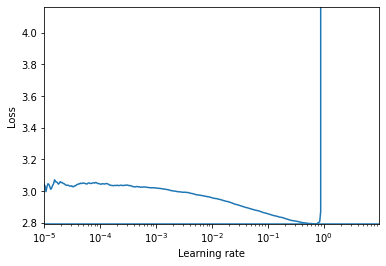

In [103]:
# 1cycle scheduling 사용
# from https://github.com/rickiepark/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb
import math

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
        
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses
        
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

        
rates, losses = find_learning_rate(model_cifar_1cycle, X_train_selu, y_train, epochs=1, batch_size=128)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [104]:
K.clear_session()

In [105]:
model_cifar_1cycle = keras.models.Sequential()
model_cifar_1cycle.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(17):
    model_cifar_1cycle.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_1cycle.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_1cycle.add(keras.layers.AlphaDropout(0.2))
model_cifar_1cycle.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_1cycle.add(keras.layers.AlphaDropout(0.2))
model_cifar_1cycle.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model_cifar_1cycle.add(keras.layers.AlphaDropout(0.2))
model_cifar_1cycle.add(RegularizedDense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-1)
model_cifar_1cycle.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [106]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [108]:
onecycle = OneCycleScheduler(math.ceil(len(X_train) / 128) * 30, max_rate=0.05)
history = model_cifar_1cycle.fit(X_train_selu, y_train, epochs=30, batch_size=128,
                    validation_data=(X_valid_selu, y_valid),
                    callbacks=[onecycle])

Epoch 1/30
352/352 [==============================] - 7s 19ms/step - loss: 1.9972 - accuracy: 0.3038 - val_loss: 2.1459 - val_accuracy: 0.3866
Epoch 2/30
352/352 [==============================] - 7s 19ms/step - loss: 1.8494 - accuracy: 0.3500 - val_loss: 2.0126 - val_accuracy: 0.4072
Epoch 3/30
352/352 [==============================] - 7s 19ms/step - loss: 1.7323 - accuracy: 0.3889 - val_loss: 1.9714 - val_accuracy: 0.4064
Epoch 4/30
352/352 [==============================] - 7s 19ms/step - loss: 1.6496 - accuracy: 0.4131 - val_loss: 1.8822 - val_accuracy: 0.4234
Epoch 5/30
352/352 [==============================] - 7s 19ms/step - loss: 1.5835 - accuracy: 0.4422 - val_loss: 1.8704 - val_accuracy: 0.4298
Epoch 6/30
352/352 [==============================] - 7s 18ms/step - loss: 1.5332 - accuracy: 0.4594 - val_loss: 1.8568 - val_accuracy: 0.4492
Epoch 7/30
352/352 [==============================] - 7s 19ms/step - loss: 1.4903 - accuracy: 0.4780 - val_loss: 1.7751 - val_accuracy: 0.4502